In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
from iminuit import Minuit
from scipy import stats
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *
from ExternalFunctions import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/Lund/'

SMPS = read_SMPS(path, parent_path, [0, 0])
OPS_APS = read_OPS(path, parent_path, 0)
MA = read_csv_BC(path + 'MA300/', parent_path, 0)

NS_dict_keys = ['2024-10-15_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan']
NS_bins = SMPS['2024-10-21_NanoScan'].keys()[3:16].to_list()

NS_bg_mean, NS_bg_std, NS_bg_error = bin_mean(['2024/10/21 11:45:00', '2024/10/21 14:10:00'], 
                                              SMPS['2024-10-21_NanoScan'], NS_bins, 'Time', 0.1)

for key in NS_dict_keys:
    df = SMPS[key]
    for i, bin in enumerate(NS_bins):
        df[bin] = df[bin] - NS_bg_mean[i]

    SMPS[key] = df

MA_dict_keys = ['MA300-0046_241016092601', 'MA300-0046_241016092601', 'MA300-0046_241017131930']
dict_keys = ['Exp1', 'Exp2', 'Exp3', 'Exp4']
OPS_mid_point = [0.337, 0.419, 0.522, 0.650, 0.809, 1.007, 1.254, 1.562, 1.944, 2.421, 3.014, 3.752, 4.672, 5.816, 7.241, 9.015]
OPS_bins = OPS_APS['Exp1'].keys()[1:17].to_list()

for dict_key in dict_keys:
    for old_key, new_key in zip(OPS_bins, OPS_mid_point):
        OPS_APS[dict_key] = OPS_APS[dict_key].rename(columns = {old_key: new_key})

OPS_cut_point = [0.300, 0.374, 0.465, 0.579, 0.721, 0.897, 1.117, 1.391, 1.732, 2.156, 2.685, 3.343, 4.162, 5.182, 6.451, 8.031, 10.000]

NS_OPS_cut = [0.010, 0.0132, 0.0179, 0.0234, 0.032, 0.0416, 0.057, 0.0739, 0.1015, 0.1314, 0.1805, 0.2337, 
              0.300, 0.374, 0.465, 0.579, 0.721, 0.897, 1.117, 1.391, 1.732, 2.156, 2.685, 3.343, 4.162, 5.182, 6.451, 8.031, 10.000]

time_wBG = [['2024-10-16 09:50:00', '2024-10-16 12:50:00'],
            ['2024-10-16 14:30:00', '2024-10-16 16:30:00'],
            ['2024-10-17 09:30:00', '2024-10-17 12:10:00'],
            ['2024-10-17 14:10:00', '2024-10-17 15:30:00']]

timestamps_exp = [['2024-10-16 10:45:00', '2024-10-16 12:26:00'],
                  ['2024-10-16 15:08:00', '2024-10-16 15:34:00'],
                  ['2024-10-17 10:20:00', '2024-10-17 12:00:00'],
                  ['2024-10-17 14:30:00', '2024-10-17 15:00:00']]

density = [7.156753166222747, 6.432320090739392, 6.150470043878313, 5.338129847104129]
NanoScan_dict_keys = ['2024-10-16_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan', '2024-10-17_NanoScan']
NS_OPS_number, NS_OPS_mass, NS_OPS_keys, NS_OPS_bin_mean = merge_data(SMPS, NanoScan_dict_keys, [3, 15], OPS_APS, dict_keys, [1, 17], time_wBG, ['Time', 'Time'], False, True, density)

Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,


2024-10-16 10:45:00
UV and IR
Mean AAE = 0.266+-0.0113, AAE 25% quantile = 0.194, AAE 75% quantile = 0.355
2024-10-16 15:08:00
UV and IR
Mean AAE = 0.258+-0.0073, AAE 25% quantile = 0.232, AAE 75% quantile = 0.279
2024-10-17 14:30:00
UV and IR
Mean AAE = 0.458+-0.0204, AAE 25% quantile = 0.397, AAE 75% quantile = 0.523
2024-10-16 10:45:00
Blue and IR
Mean AAE = 0.406+-0.0230, AAE 25% quantile = 0.159, AAE 75% quantile = 0.596
2024-10-16 15:08:00
Blue and IR
Mean AAE = 0.503+-0.0120, AAE 25% quantile = 0.458, AAE 75% quantile = 0.551
2024-10-17 14:30:00
Blue and IR
Mean AAE = 0.697+-0.0452, AAE 25% quantile = 0.417, AAE 75% quantile = 1.005
2024-10-16 10:45:00
Green and IR
Mean AAE = 0.455+-0.0274, AAE 25% quantile = 0.148, AAE 75% quantile = 0.681
2024-10-16 15:08:00
Green and IR
Mean AAE = 0.576+-0.0146, AAE 25% quantile = 0.505, AAE 75% quantile = 0.634
2024-10-17 14:30:00
Green and IR
Mean AAE = 0.743+-0.0556, AAE 25% quantile = 0.408, AAE 75% quantile = 1.128
2024-10-16 10:45:00
Re

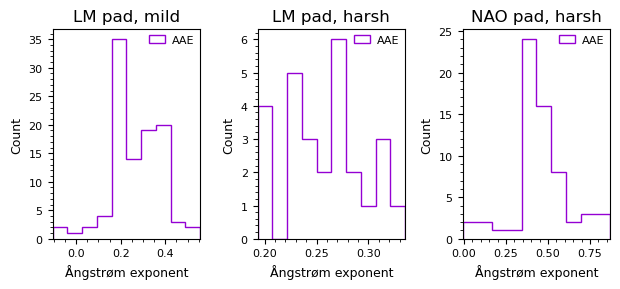

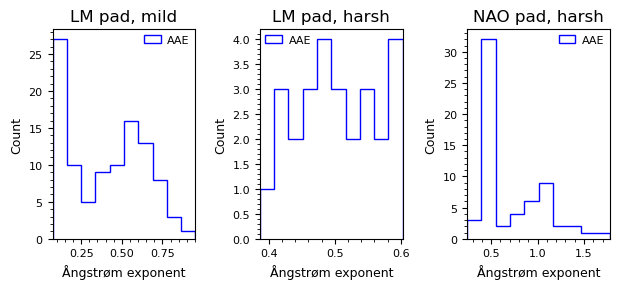

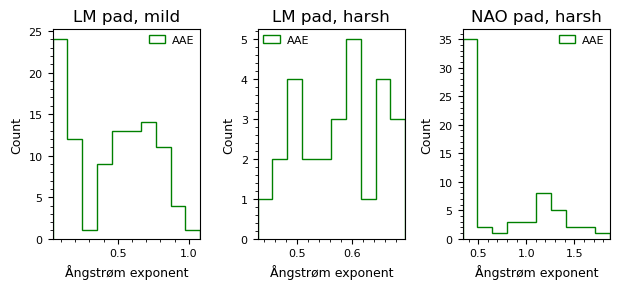

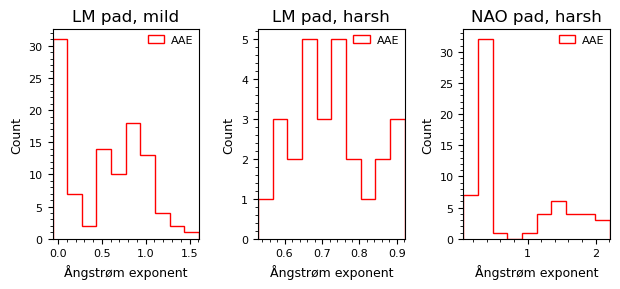

In [3]:
timestamps_124 = [['2024-10-16 10:45:00', '2024-10-16 12:26:00'],
                  ['2024-10-16 15:08:00', '2024-10-16 15:34:00'],
                  ['2024-10-17 14:30:00', '2024-10-17 15:00:00']]

titles = ['LM pad, mild', 'LM pad, harsh', 'NAO pad, harsh']
names = ['UV-IR', 'Blue-IR', 'Green-IR', 'Red-IR']

figs, axes, AAE = AAE_hist(1, 3, (6.3, 3), MA, MA_dict_keys, timestamps_124, 10, None, None, False)

for i, ax in enumerate(axes):
    for j, ttl in enumerate(titles):
        ax[j].set_title(ttl)
    figs[i].tight_layout()
    figs[i].savefig(f'Gaussian_fits/BWP_AAE_{names[i]}.png', dpi = 600)

Exp1
[8.17581420e+00 4.90674309e-02 4.33958338e-01 4.71028815e+01
 7.63488499e-01 8.75532635e-01 6.19891275e+01 1.54486195e-01
 4.06700018e-01]
1.5873049875391454e-07
[2.25248985e+03 6.79524782e+00 8.18785987e-01 5.39935058e+00
 5.55538995e-01 6.72963921e-01]
1.5138438809500305e-14
Exp2
[2.68883746e+02 1.44744081e-01 3.57080718e-01 2.25616337e+02
 6.77273831e-01 9.01979580e-01 9.65676871e+01 6.83914785e-02
 5.47057833e-01]
2.7257308906533366e-07
[8.30876519e+03 6.91579298e+00 8.45633006e-01 1.28656855e+01
 4.41293887e-01 6.60518945e-01]
1.3895045073843862e-12
Exp3
[-2.52587266e+02  2.45953841e-01  9.17252648e-01  3.16401698e+02
  2.64371721e-01  9.47363117e-01 -2.49359958e+01  2.47707264e-01
  1.67895927e-01]
1.185392862103423e-12
[2.51290179e-01 2.94878236e-01 5.35296108e-01 4.75224951e+02
 4.05864446e+00 7.43845534e-01]
3.7805245956238765e-50
Exp4
[ 9.66102716e+00  3.67074558e-02  3.35719484e-01 -5.91178670e+02
  2.21981516e-01  6.88200278e-01  4.08102783e+02  5.00268165e-01
  8.4791

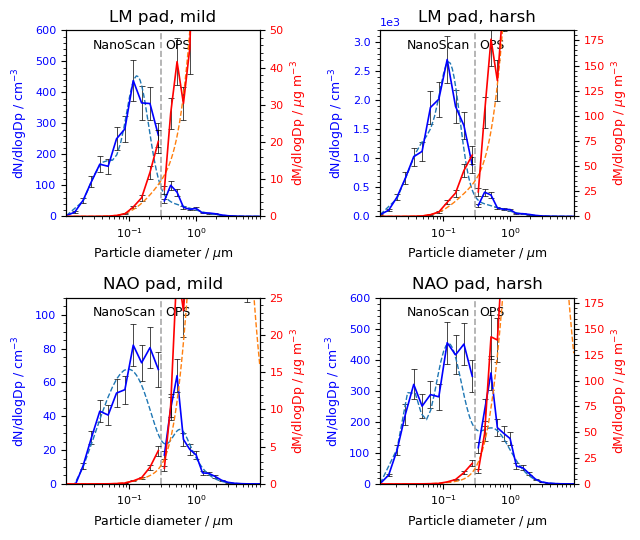

In [4]:
initial_number = [{'p1': 64, 'mu1': 0.14, 'sigma1': 0.67, 'p2': 39, 'mu2': 0.91, 'sigma2': 0.82, 'p3': 30, 'mu3': 0.3, 'sigma3': 0.5},
                  {'p1': 64, 'mu1': 0.14, 'sigma1': 0.67, 'p2': 39, 'mu2': 0.91, 'sigma2': 0.82, 'p3': 30, 'mu3': 0.3, 'sigma3': 0.5},
                  {'p1': -500, 'mu1': 0.15, 'sigma1': 0.69, 'p2': 400, 'mu2': 0.5, 'sigma2': 0.8, 'p3': -100, 'mu3': 0.05, 'sigma3': 0.33}, 
                  {'p1': 64, 'mu1': 0.03, 'sigma1': 0.67, 'p2': 39, 'mu2': 0.15, 'sigma2': 0.82, 'p3': 30, 'mu3': 0.5, 'sigma3': 0.5, 'p4': 30, 'mu4': 1, 'sigma4': 0.5}]
fit_func_number = [t_loggauss, t_loggauss, dlognorm_gauss, q_loggauss]

initial_mass = [{'p1': 500, 'mu1': 20, 'sigma1': 0.2, 'p2': 10, 'mu2': 1, 'sigma2': 0.5},
                {'p1': 700, 'mu1': 10, 'sigma1': 0.5, 'p2': 10, 'mu2': 1, 'sigma2': 0.5},         # 'p3': 30, 'mu3': 0.3, 'sigma3': 0.5},
                {'p1': 64, 'mu1': 1, 'sigma1': 0.69, 'p2': 40, 'mu2': 3, 'sigma2': 0.8},        # 'p3': -100, 'mu3': 0.05, 'sigma3': 0.33}, 
                {'p1': 64, 'mu1': 1, 'sigma1': 0.67, 'p2': 39, 'mu2': 3, 'sigma2': 0.82}]         #, 'p3': 30, 'mu3': 0.5, 'sigma3': 0.5, 'p4': 30, 'mu4': 1, 'sigma4': 0.5}]
fit_func_mass = [d_loggauss, d_loggauss, d_loggauss, d_loggauss]

y_max = [[600, 50],
         [3200, 185],
         [110, 25],
         [600, 180]]

titles = ['LM pad, mild', 'LM pad, harsh', 'NAO pad, mild', 'NAO pad, harsh']
fig, axes = plt.subplots(2, 2, figsize = (6.5, 5.5))

for i, ax in enumerate(axes.flatten()):

    print(dict_keys[i])

    ax, fit_params, fit_errors, df_mean = plot_fitted_mean(ax, timestamps_exp[i], NS_OPS_number[dict_keys[i]], NS_OPS_keys, 'Time', 0.15, 
                                                        NS_OPS_bin_mean, NS_OPS_cut, 0.3, fit_func_number[i], ['b', 'tab:blue'], 
                                                        initial_number[i])
    ax.vlines(0.3, 0, y_max[i][0], colors = 'darkgrey', linestyles = '--')
    ax.text(0.25, y_max[i][0] - 0.1*y_max[i][0], 'NanoScan', ha = 'right', fontsize = 9)
    ax.text(0.35, y_max[i][0] - 0.1*y_max[i][0], 'OPS', ha = 'left', fontsize = 9)
    ax.set(xscale = 'log', title = titles[i], xlabel = 'Particle diameter / $\mu$m', ylim = (0, y_max[i][0]))
    ax.set_ylabel('dN/dlogDp / cm$^{-3}$', color = 'b')
    ax.tick_params(axis = 'y', labelcolor = 'b')
    
    ax2 = ax.twinx()
    ax2, fit_params, fit_errors, df_mean = plot_fitted_mean(ax2, timestamps_exp[i], NS_OPS_mass[dict_keys[i]], NS_OPS_keys, 'Time', 0.15, 
                                                        NS_OPS_bin_mean, NS_OPS_cut, 0.3, fit_func_mass[i], ['r', 'tab:orange'],
                                                        initial_mass[i])
    ax2.set_ylim(0, y_max[i][1])
    ax2.set_ylabel('dM/dlogDp / $\mu$g m$^{-3}$', color = 'r')
    ax2.tick_params(axis = 'y', labelcolor = 'r')

fig.tight_layout()
fig.savefig('Gaussian_fits/NS_OPS_fitted.png', dpi = 600)